<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# End-of-Day Trading Rules

Momentum investing says that excess returns can be generated by buying recent winners. In this notebook we will use Zipline's Pipeline API to research the momentum factor on our sample data.

## Zipline Strategy Structure

When developing a Zipline strategy, a good first step is to consider which of your trading rules utilize end-of-day data and which ones utilize intraday data. 

A typical Zipline strategy uses the Pipeline API for end-of-day trading logic. Zipline "pipelines" run once per trading day before the market opens and are used to compute alpha factors based on prior day data, and also to filter large universes down to a manageable number of securities based on these alpha factors. 

A typical Zipline strategy then uses intraday data (which in live trading comes from a real-time data feed) to apply additional trading logic to this filtered universe of securities and make trading decisions throughout the trading day.

## Run Pipeline
You can create and run pipelines interactively in a notebook. Although you could proceed directly to writing your Zipline strategy in a `.py` file, starting in a notebook is a great way to validate your code interactively before transitioning to a backtest, where debugging can be more laborious. 

The first step is to define the pipeline. A pipeline has two main attributes: `columns`, which is used to calculate one or more factors, and `screen`, which is used to filter the pipeline to a subset of securities. Here, we filter the starting universe to include only stocks with 30-day average dollar volume of at least 10 million dollars, and for these securities we calculate a 12-month return:

In [1]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 200
N_SHORTS = 0
VOL_SCREEN = 1000

In [3]:

import pandas as pd
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume


In [4]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=1)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

In [49]:
"""Create factor pipeline incl. mean reversion,
    filtered by 30d Dollar Volume; capture factor ranks"""
mean_reversion = MeanReversion()
dollar_volume = AverageDollarVolume(window_length=30)
longs = mean_reversion.bottom(N_LONGS)
shorts = mean_reversion.top(N_SHORTS)
pipeline = Pipeline(columns={'longs': longs,
                            'shorts': shorts,
                            'ranking': mean_reversion.rank(ascending=False),
                            "returns": Returns(window_length=252)
                            },
                screen=dollar_volume.top(VOL_SCREEN))

In [1]:
# from zipline.pipeline import Pipeline
# from zipline.pipeline.factors import AverageDollarVolume, Returns

# pipeline = Pipeline(
#     columns={
#         "returns": Returns(window_length=252),
#     },
#     screen=AverageDollarVolume(window_length=30) > 10e6
# )

The above code merely defines the pipeline but does not return any data. To compute the pipeline, we must run it on our sample data bundle. 

Since we will be using the same data bundle repeatedly in our analysis, we can set it as the default bundle to avoid always having to type the name of the bundle:

In [32]:
from quantrocket.zipline import set_default_bundle
set_default_bundle("usstock-1min")

{'status': 'successfully set default bundle'}

And now we run the pipeline:

In [50]:
from zipline.research import run_pipeline
factors = run_pipeline(pipeline, start_date="2021-01-01", end_date="2023-05-12")
factors.tail()

longs  shorts  \
date                      asset                                           
2023-05-12 00:00:00+00:00 Equity(FIBBG019X46Z37 [MBLY])   False   False   
                          Equity(FIBBG001Z0QVH3 [GEHCV])   True   False   
                          Equity(FIBBG01BFR8YV1 [GEHC])    True   False   
                          Equity(FIBBG01FND0CC1 [LIN])    False   False   
                          Equity(FIBBG01C79X561 [KVUE])   False   False   

                                                          ranking  returns  
date                      asset                                             
2023-05-12 00:00:00+00:00 Equity(FIBBG019X46Z37 [MBLY])    9304.0      NaN  
                          Equity(FIBBG001Z0QVH3 [GEHCV])  10051.0      NaN  
                          Equity(FIBBG01BFR8YV1 [GEHC])   10075.0      NaN  
                          Equity(FIBBG01FND0CC1 [LIN])     8686.0      NaN  
                          Equity(FIBBG01C79X561 [KVUE])       NaN      NaN

For each date in the requested date range, the resulting DataFrame contains a row for each security that passed our `screen` on that date, plus a column for each of our requested factors in `columns`. 


The `run_pipeline` function is only used in notebooks. In a Zipline strategy, you access pipeline results one date at a time (through the `pipeline_output` function). To get the exact data structure you'll use in Zipline, simply select a single date like this: 

In [36]:
factors_xs = factors.xs("2023-05-12")
factors_xs.head()

,longs,shorts,ranking,returns
asset,,,,
Equity(FIBBG000C2V3D6 [A]),False,False,9638.0,0.127358
Equity(FIBBG00B3T3HD3 [AA]),False,False,7605.0,-0.371400
Equity(FIBBG005P7Q881 [AAL]),False,False,831.0,-0.118973
Equity(FIBBG000F7RCJ1 [AAP]),False,False,1685.0,-0.356895
Equity(FIBBG000B9XRY4 [AAPL]),False,False,1488.0,0.192945


By selecting a single day of pipeline output in a notebook, you can go ahead and write the end-of-day trading logic you will use in your strategy, and later transfer it to a `.py` file. Here, we sort the pipeline output by one-year returns and select the top 3 securities. These are the stocks our example strategy will buy.

In [51]:
returns = factors["returns"].sort_values(ascending=False)
winners = returns.index[:3]
winners

MultiIndex([('2021-04-06 00:00:00+00:00', Equity(FIBBG001K7WBT8 [MARA])),
            ('2021-04-01 00:00:00+00:00', Equity(FIBBG001K7WBT8 [MARA])),
            ('2021-04-14 00:00:00+00:00', Equity(FIBBG001K7WBT8 [MARA]))],
           names=['date', 'asset'])

In [52]:
returns.index.get_level_values(1).unique()

Index([ Equity(FIBBG001K7WBT8 [MARA]),  Equity(FIBBG000BVKXQ5 [MVIS]),
        Equity(FIBBG000BQ4512 [RIOT]),   Equity(FIBBG000BB5BF6 [GME]),
        Equity(FIBBG00194VJB1 [OCGN]),  Equity(FIBBG00202QNG4 [TKAT]),
        Equity(FIBBG000NVSBL7 [NVAX]),  Equity(FIBBG000BMXYW2 [KOSS]),
        Equity(FIBBG000BK9YW3 [SAVA]),  Equity(FIBBG000CX5677 [ERNA]),
       ...
       Equity(FIBBG001Z0QVH3 [GEHCV]),  Equity(FIBBG01BFR8YV1 [GEHC]),
        Equity(FIBBG0193YH501 [TSLL]),    Equity(FIBBG018KBK3G8 [NE]),
         Equity(FIBBG00W5FLW97 [GNS]),   Equity(FIBBG01FND0CC1 [LIN]),
        Equity(FIBBG017304ND0 [SOUN]),  Equity(FIBBG01G26Y9Y3 [USCA]),
         Equity(FIBBG012GNQ2N8 [TOP]),  Equity(FIBBG01C79X561 [KVUE])],
      dtype='object', name='asset', length=1928)

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1,-0.992,0.527,-0.307,0.280,"111,463",194.9,20.0%
2,-0.395,0.866,0.003,0.228,"111,135",194.3,20.0%
3,-0.255,1.303,0.153,0.269,"111,115",194.3,20.0%
4,-0.133,2.408,0.348,0.371,"111,135",194.3,20.0%
5,0.030,121.957,1.584,3.973,"111,351",194.7,20.0%


,1D
Ann. alpha,-0.095
beta,-0.037
Mean Relative Return Top Quantile (bps),-1.384
Mean Relative Return Bottom Quantile (bps),-1.641
Mean Spread (bps),0.257


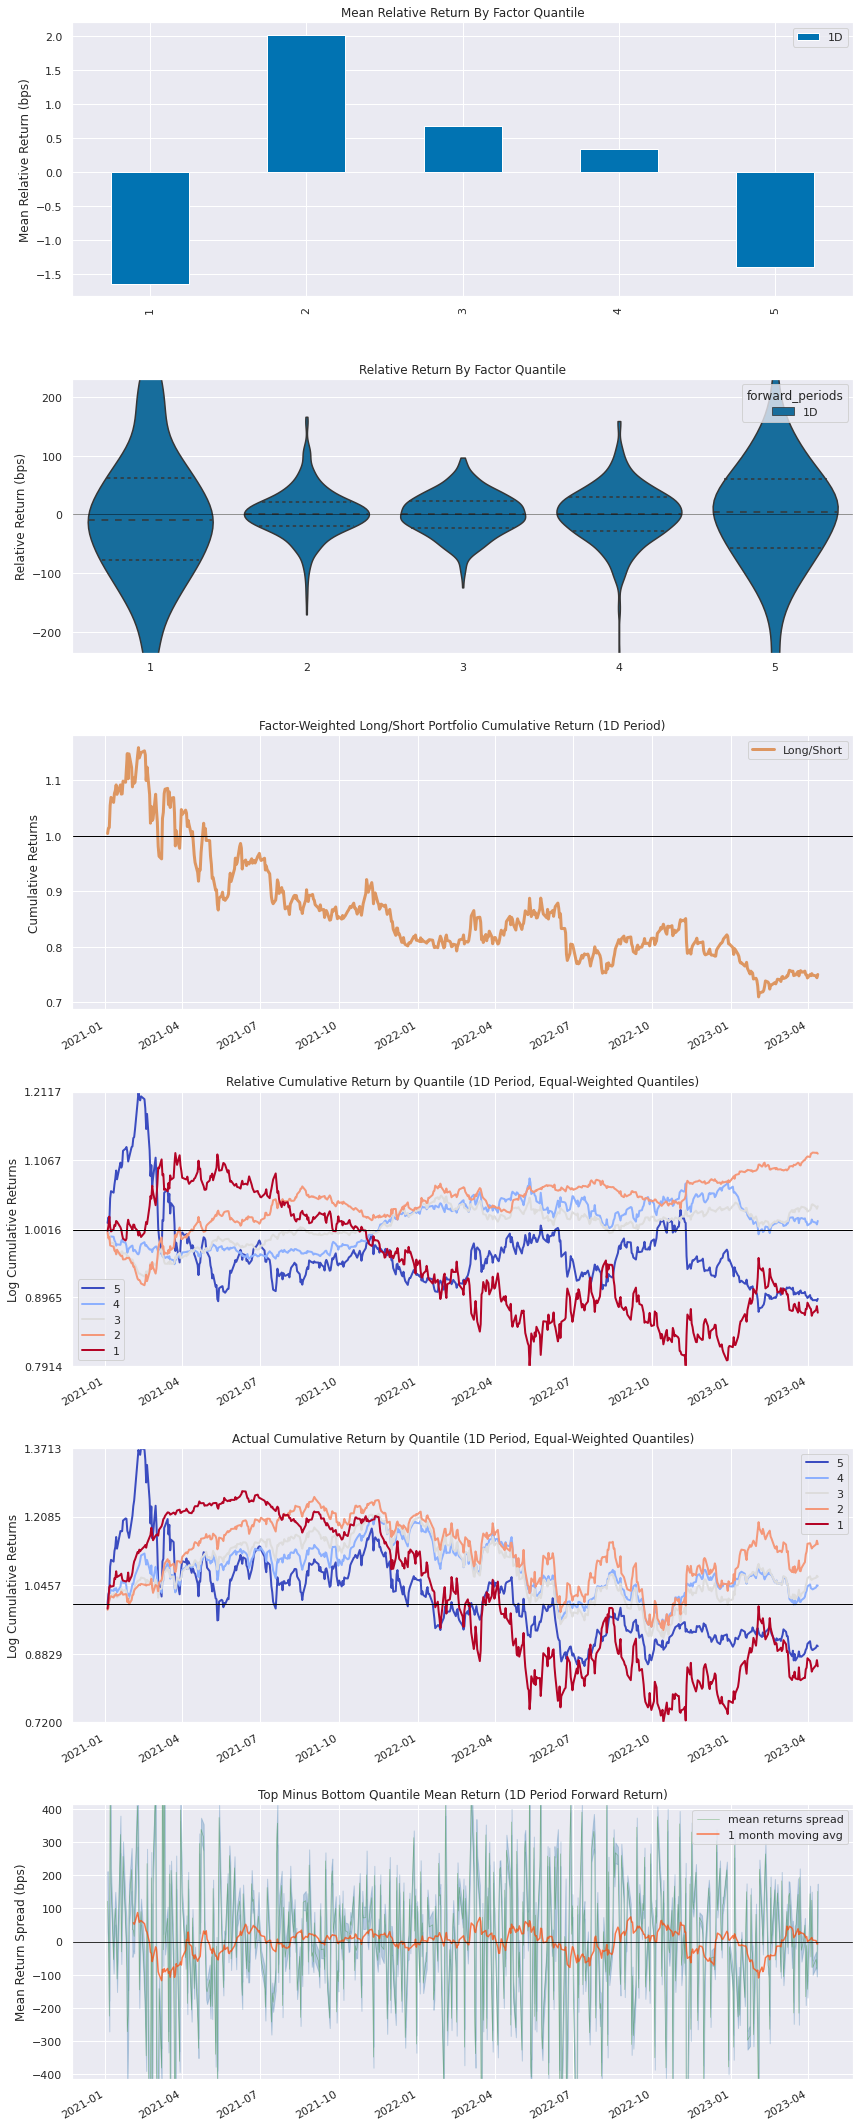

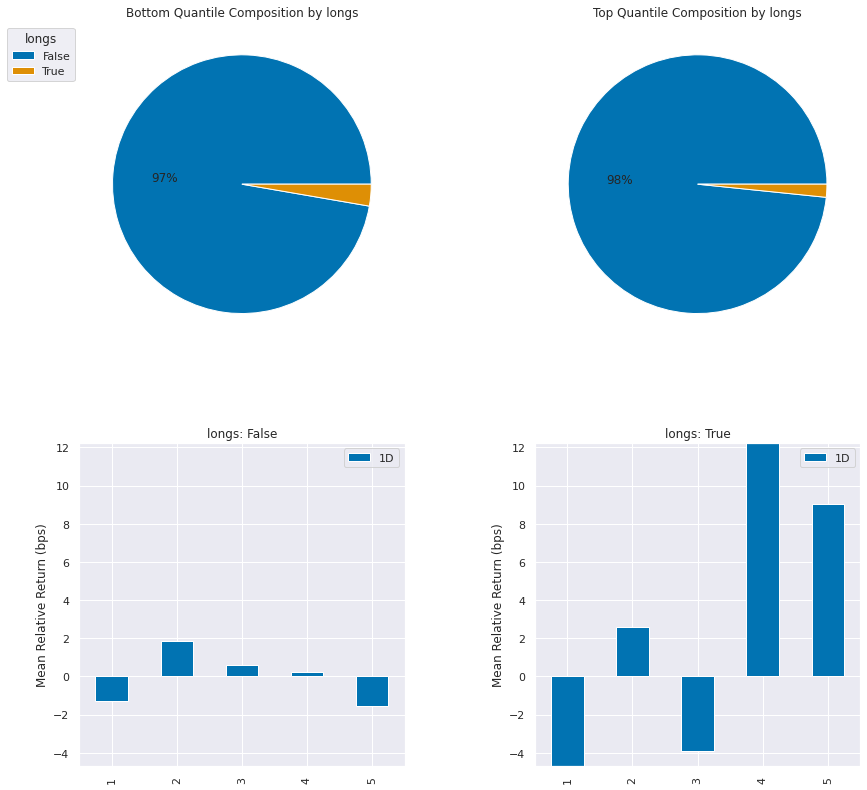

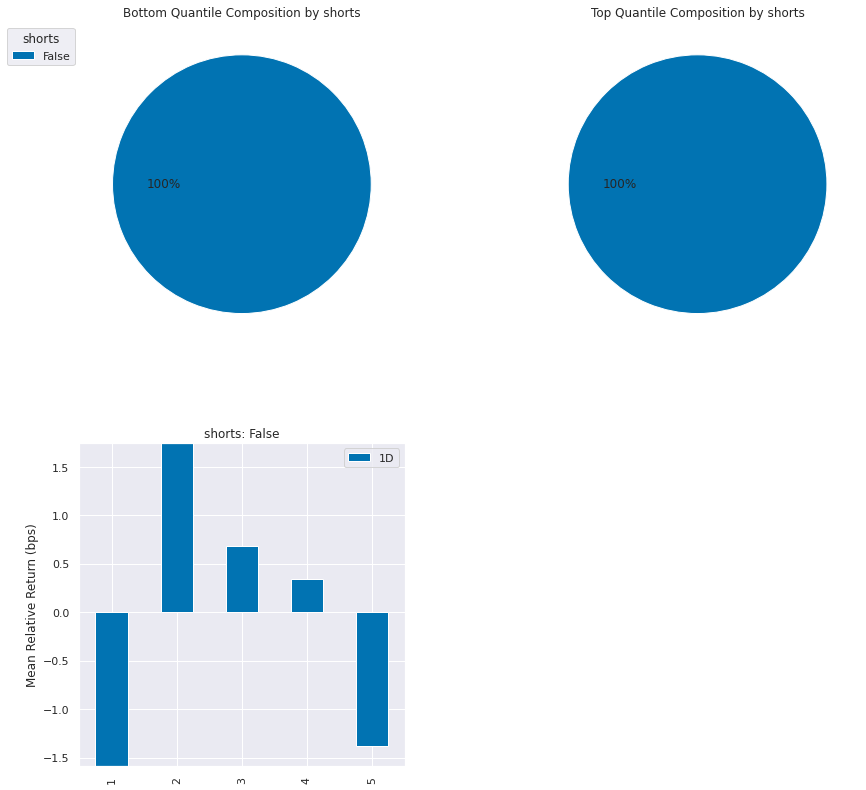

,1D
IC Mean,0.010
IC Std.,0.271
Risk-Adjusted IC,0.039
t-stat(IC),0.921
p-value(IC),0.357
IC Skew,-0.174
IC Kurtosis,-0.608


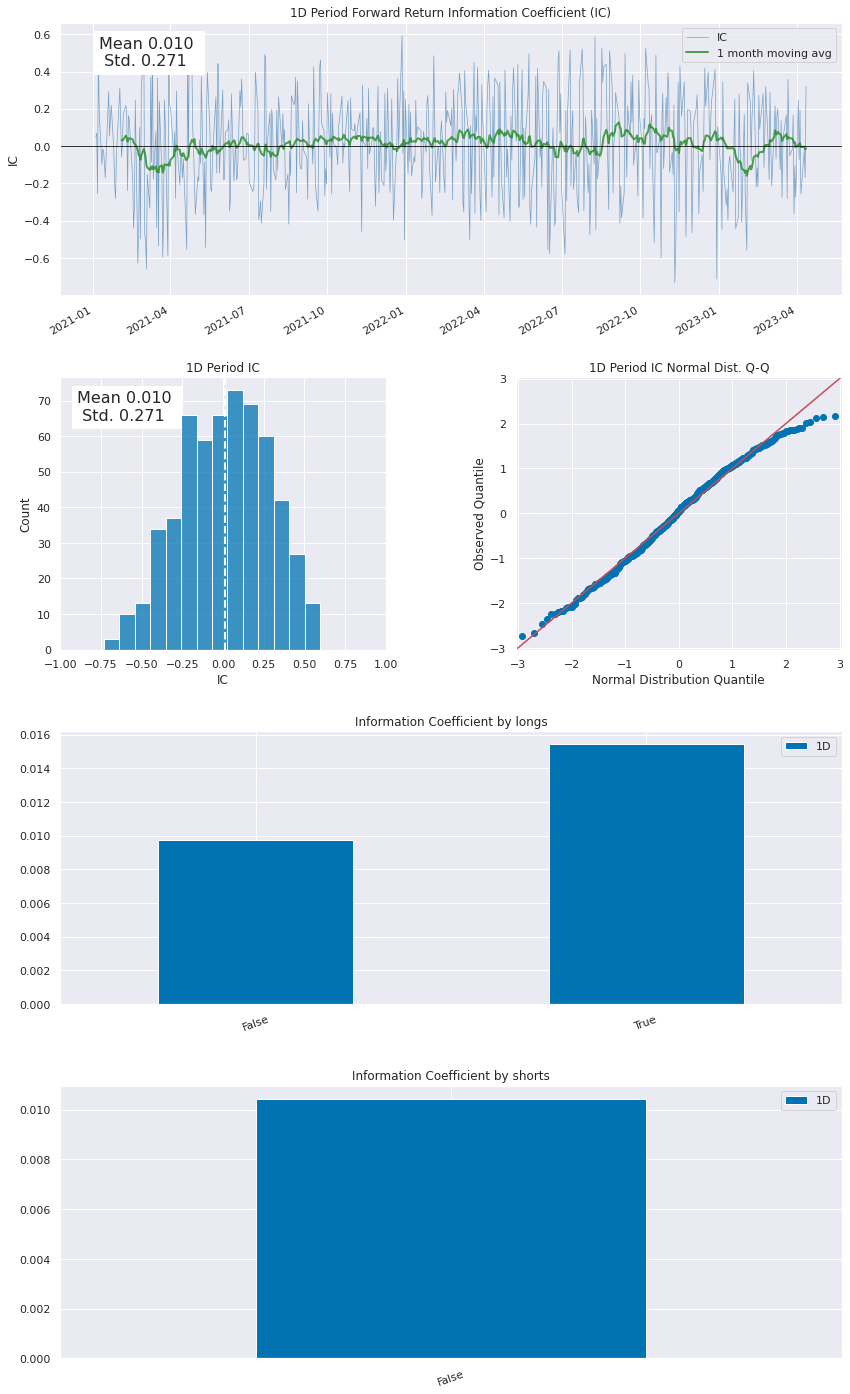

,1D
Quantile 1 Mean Turnover,0.046
Quantile 2 Mean Turnover,0.108
Quantile 3 Mean Turnover,0.132
Quantile 4 Mean Turnover,0.113
Quantile 5 Mean Turnover,0.051


,1D
Mean Factor Rank Autocorrelation,0.994


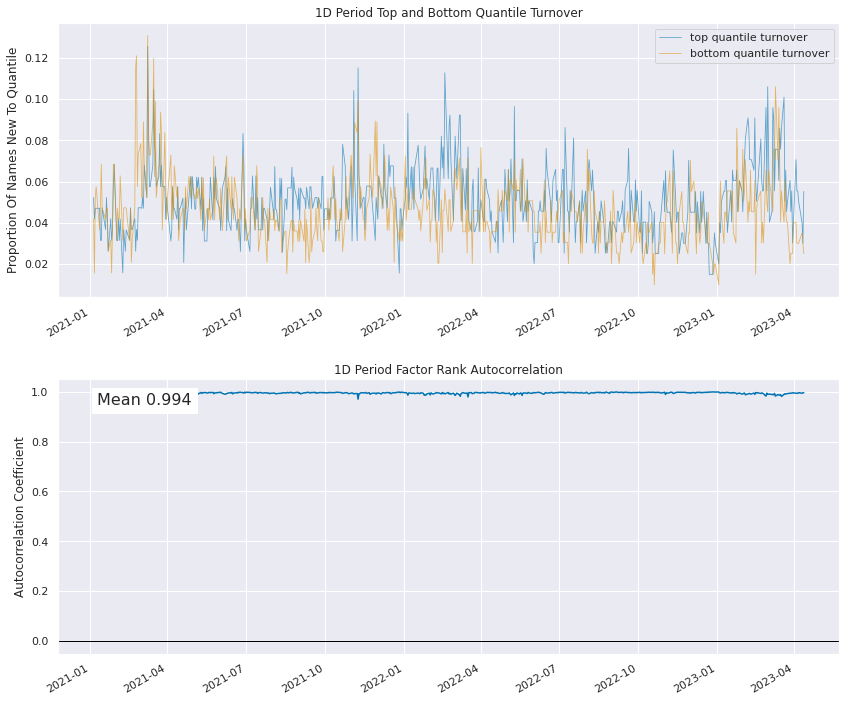

In [54]:
import alphalens as al

al.from_pipeline(
    pipeline, 
    # the `factor` argument tells which Pipeline column to use to form the quantiles
    factor="returns",
    start_date="2021-01-01", 
    end_date="2023-04-12",
    groupby=['longs', 'shorts'],
    # For a very small sample universe, you might only want 2 quantiles 
    quantiles=5
)

***

## *Next Up*

Part 3: [End-of-Day Analysis With Alphalens](Part3-End-of-Day-Analysis-With-Alphalens.ipynb)